## Проект: Оценка рисков ДТП
Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП __с любым повреждением транспортного средства__. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

## Подключитесь к базе. Загрузите таблицы sql

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install sqlalchemy

In [ ]:
!pip install shap

In [ ]:
# Загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   LabelEncoder
                                  )
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    GridSearchCV
)

from sqlalchemy import create_engine

import shap

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

In [ ]:
# Строка для подключения к БД
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [ ]:
# Создаем соединение
engine = create_engine(connection_string)

## Проведите первичное исследование таблиц

In [ ]:
def table_out(table_name):
    """
    Функция выполнения запроса по выводу содержимого таблицы
    """
    query_collisions = f'''
                    SELECT *
                    FROM {table_name}
                    LIMIT 5
                    '''
    df = pd.read_sql_query(query_collisions, con = engine)
    return df

In [ ]:
# Общая информация о ДТП
table_collisions = table_out('collisions')
table_collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Описание таблицы __collisions:__   
Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

In [ ]:
# Информация об участниках ДТП
table_parties = table_out('parties')
table_parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Описание таблицы __parties:__    
Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

In [ ]:
# Информация о пострадавших машинах
table_vehicles = table_out('vehicles')
table_vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


Описание таблицы __vehicles:__   
Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

__Вывод:__
1) Количество таблиц соответствует условию задачи;    
2) Все таблицы имеют общий ключ для связи.

##  Проведите статистический анализ факторов ДТП

Выясним, в какие __месяцы__ происходит __наибольшее__ количество аварий. Проанализируем весь период наблюдений (таблица collisions).

In [ ]:
query = """
SELECT
    EXTRACT(YEAR FROM collision_date) AS year,
    EXTRACT(MONTH FROM collision_date) AS month,
    COUNT(*) AS accident_count
FROM
    collisions
GROUP BY
    EXTRACT(YEAR FROM collision_date),
    EXTRACT(MONTH FROM collision_date)
HAVING
    COUNT(*) > 0
ORDER BY
    year, month;
"""

In [ ]:
accident_df = pd.read_sql_query(query, con = engine)

In [ ]:
accident_df

,year,month,accident_count
0,2009.0,1.0,35062
1,2009.0,2.0,34480
2,2009.0,3.0,36648
3,2009.0,4.0,35239
4,2009.0,5.0,36916
5,2009.0,6.0,34202
6,2009.0,7.0,35161
7,2009.0,8.0,34508
8,2009.0,9.0,35555
9,2009.0,10.0,37835


Заметим, что 2012, 2013 и 2020 года являются неполными в сравнении с другими. Они могут сказаться не очень на обучении модели, но по условию заказчика, мы должны их оставить

In [ ]:
filtered_df = accident_df[accident_df['year'] < 2012]

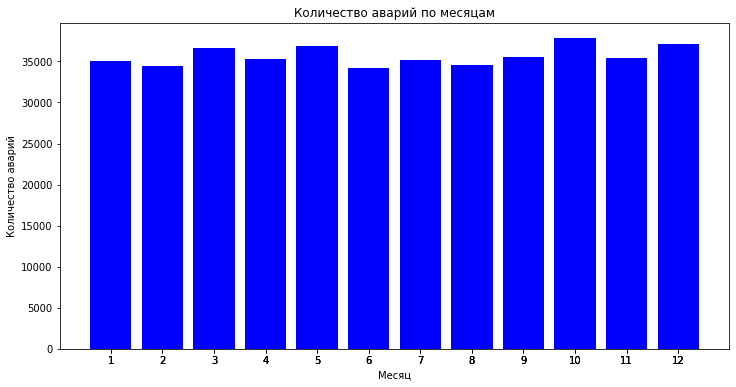

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(filtered_df['month'], filtered_df['accident_count'], color='blue')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.title('Количество аварий по месяцам')
plt.xticks(filtered_df['month'])
plt.show()

__Вывод:__    
Наибольшее число аварий происходит в 3, 5 и 10 месяцы.

### Задачи для коллег на совещание

1. Определите самые частые причины для ДТП (таблица parties);
2. Определите серьезность происшествий из-за погодных условий (таблица collisions);
3. Определите зависимости между типом автомобиля и серьезностью аварии (связать таблицы vehicles и collisions);
4. Определите самые частые категорий нарушений (таблица collsions);
5. Проведите сравнение типов автомобилей по количеству аварий (таблица vehicles);
6. Определите серьезность происшествий в зависимотси от трезвости участника (связать таблицы parties и collisions);
7. Определите количество дтп в зависимотси от трезвости участника (связать таблицы parties и collisions).

### Порядок решения задач

#### Задача 1: Определите серьезность происшествий в зависимотси от трезвости участника (связать таблицы parties и collisions)

1. Создайте sql-запрос

In [ ]:
query = '''
SELECT p.party_sobriety,
       c.collision_damage,
       COUNT(*)
FROM parties p
JOIN collisions c
    ON p.case_id = c.case_id
GROUP BY
    c.collision_damage, p.party_sobriety;

'''

In [ ]:
party_sobriety_depend = pd.read_sql_query(query, con = engine)

2. Постройте график (если возможно)

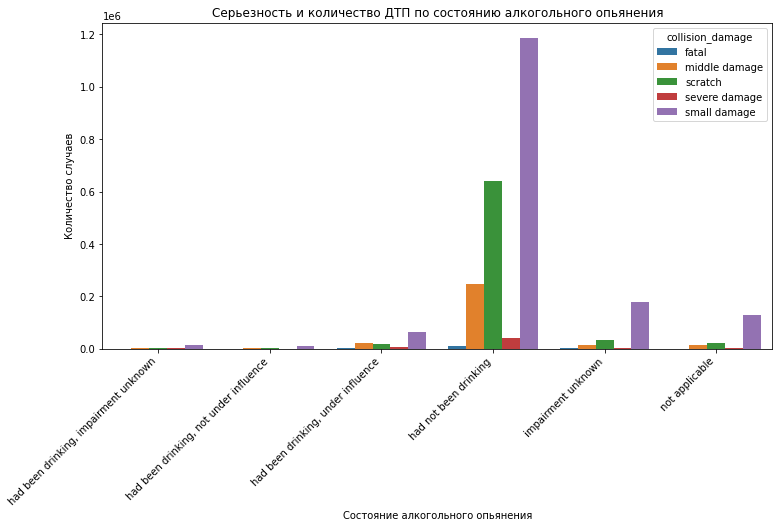

In [ ]:
# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x='party_sobriety', y='count', hue = 'collision_damage', data=party_sobriety_depend)
plt.title('Серьезность и количество ДТП по состоянию алкогольного опьянения')
plt.xlabel('Состояние алкогольного опьянения')
plt.ylabel('Количество случаев')
plt.xticks(rotation=45, ha='right')
plt.show()

3. Сделайте вывод

__Вывод:__
Из графика видно, что большинство ДТП происходит с водителями, которые не употребляли алкоголь. Однако, важно отметить, что ДТП с участием водителей, находящихся под влиянием алкоголя, также имеют место. Это подчеркивает важность учета уровня трезвости водителя для предотвращения ДТП.

#### Задача 2: Определите зависимости между типом автомобиля и серьезностью аварии (связать таблицы vehicles и collisions)

1. Создайте sql-запрос

In [ ]:
query = '''
SELECT v.vehicle_type,
       c.collision_damage,
       COUNT(*)
FROM vehicles v
JOIN collisions c
    ON v.case_id = c.case_id
GROUP BY
    c.collision_damage, v.vehicle_type;

'''

In [ ]:
type_car_depend = pd.read_sql_query(query, con = engine)

2. Постройте график (если возможно)

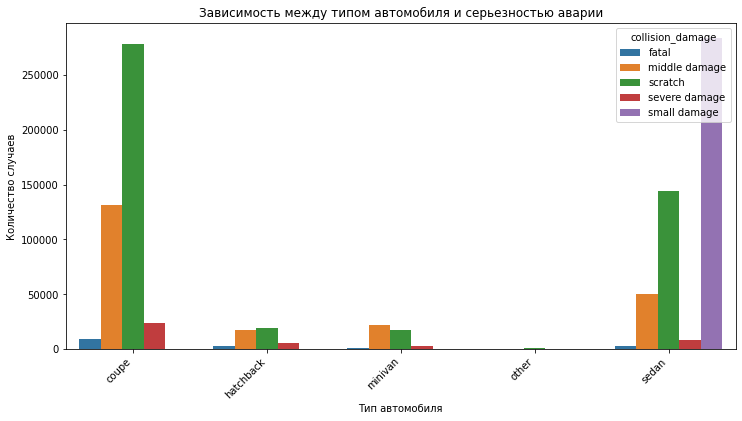

In [ ]:
# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x='vehicle_type', y='count', hue = 'collision_damage', data=type_car_depend)
plt.title('Зависимость между типом автомобиля и серьезностью аварии')
plt.xlabel('Тип автомобиля')
plt.ylabel('Количество случаев')
plt.xticks(rotation=45, ha='right')
plt.show()

3. Сделайте вывод

__Вывод:__По графику видим, что наибольшее число ДТП происходит на авто типа седан. Эти ДТП характеризуются как небольшие

## Создайте модель для оценки водительского риска

Отберем факторы, которые необходимы для модели и подготовим набор данных

Факторы:   
1) __party_sobriety:__ Уровень трезвости участника. Этот фактор прямо влияет на способность водителя управлять автомобилем и является критически важным для оценки риска;     
2) __at_fault:__ Указывает на виновность участника (виновен или нет). Это поможет определить, насколько часто водители, признанные виновными, участвуют в серьезных ДТП;     
3) __vehicle_type:__ Тип кузова автомобиля. Разные кузова имеют свои скоростные характеристики, свой уровень безопасноти и маневренности;   
4) __vehicle_transmission:__ Тип коробки передач (автоматическая или ручная). Это может влиять на управление автомобилем в экстренных ситуациях;  
5) __vehicle_age:__ Возраст автомобиля. Более старые автомобили могут быть менее безопасными из-за устаревших технологий и износа;     
6) __collision_date:__ Дата происшествия. Важно учитывать временные аспекты, такие как сезонные изменения или время суток;                 
7) __weather_1:__ Погодные условия во время происшествия. Плохая погода может значительно увеличить риск аварийности;  
8) __road_surface:__ Состояние дорожного покрытия в момент ДТП. Это также влияет на безопасность вождения и вероятность аварии;    
9) __lighting:__ Условия освещения во время происшествия (дневное время, темнота и т.д.). Это может влиять на видимость и, соответственно, на вероятность ДТП;  
10) __road_condition_1:__ Состояние дороги (Ямы, глубокая колея, cыпучий материал на проезжей части и тд);   
11) __insurance_premium:__ Сумма страховки (тыс. долларов);   
12) __intersection:__ Является ли место происшествие перекрёстком;   
13) __cellphone_in_use:__ Наличие телефона в автомобиле (возможности разговаривать по громкой связи);   
14) __county_city_location:__ Номер географических районов, где произошло ДТП;  
15) __county_location:__ Названия географических районов, где произошло ДТП;   
16) __direction:__ Направление движения;  
17) __distance:__ Расстояние от главной дороги (метры);  

целевое значение — at_fault (виновник) в таблице parties

Набор данных

In [ ]:
query = '''
SELECT
    p.party_sobriety,
    p.at_fault,
    p.insurance_premium,
    p.cellphone_in_use,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age,
    c.collision_date,
    c.weather_1,
    c.road_surface,
    c.lighting,
    c.road_condition_1,
    c.intersection,
    c.county_city_location,
    c.county_location,
    c.direction,
    c.distance

FROM parties AS p
JOIN vehicles AS v
    ON p.case_id = v.case_id AND p.party_number = v.party_number
JOIN collisions c
    ON p.case_id = c.case_id
WHERE
    p.party_type = 'car'  -- Только автомобили
    AND c.collision_damage <> 'scratch'  -- Исключаем царапины
    AND EXTRACT(YEAR FROM c.collision_date) = 2012;  -- Данные только за 2012 год
'''

In [ ]:
factors = pd.read_sql_query(query, con = engine)

In [ ]:
factors.head()

,party_sobriety,at_fault,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,collision_date,weather_1,road_surface,lighting,road_condition_1,intersection,county_city_location,county_location,direction,distance
0,impairment unknown,1,37.60717,0.0,sedan,manual,3.0,2012-01-20,clear,dry,dark with street lights,normal,0.0,3711,san diego,south,1500.0
1,had not been drinking,0,46.00000,0.0,sedan,auto,2.0,2012-04-15,clear,dry,daylight,normal,0.0,1942,los angeles,south,20.0
2,"had been drinking, under influence",1,38.00000,0.0,sedan,auto,5.0,2012-05-01,clear,dry,dark with no street lights,other,0.0,4100,san mateo,east,40.0
3,had not been drinking,0,67.00000,0.0,sedan,auto,10.0,2012-04-19,clear,dry,daylight,normal,1.0,2002,madera,north,0.0
4,had not been drinking,0,41.00000,0.0,sedan,auto,5.0,2012-03-16,cloudy,dry,dusk or dawn,normal,0.0,0109,alameda,west,500.0


Проведем статистическое исследование отобранных факторов

In [ ]:
print(f'Количество строк - {factors.shape[0]}\nКоличество столбцов - {factors.shape[1]}')

Количество строк - 56248
Количество столбцов - 17


In [ ]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   party_sobriety        55376 non-null  object 
 1   at_fault              56248 non-null  int64  
 2   insurance_premium     55701 non-null  float64
 3   cellphone_in_use      51777 non-null  float64
 4   vehicle_type          56248 non-null  object 
 5   vehicle_transmission  55389 non-null  object 
 6   vehicle_age           54554 non-null  float64
 7   collision_date        56248 non-null  object 
 8   weather_1             56080 non-null  object 
 9   road_surface          55900 non-null  object 
 10  lighting              56094 non-null  object 
 11  road_condition_1      55999 non-null  object 
 12  intersection          56073 non-null  float64
 13  county_city_location  56248 non-null  object 
 14  county_location       56248 non-null  object 
 15  direction          

In [ ]:
factors.isna().sum()

party_sobriety            872
at_fault                    0
insurance_premium         547
cellphone_in_use         4471
vehicle_type                0
vehicle_transmission      859
vehicle_age              1694
collision_date              0
weather_1                 168
road_surface              348
lighting                  154
road_condition_1          249
intersection              175
county_city_location        0
county_location             0
direction               13018
distance                    0
dtype: int64

Видим, что в данных есть пропуски. Их небольшое количество, следовательно, имеем такие варианты решения:
1) Заполнить категориальные - модой, а количественные - медианой;     
2) Удалить пропущенные значения (сохраниться более 90% данных);  
3) Заполнить пропуски словами 'Неизвестно'.  

In [ ]:
# Удалим пропуски
factros = factors.dropna(subset=['cellphone_in_use'])

In [ ]:
factors['cellphone_in_use'] = factors['cellphone_in_use'].astype(str)
factors['at_fault'] = factors['at_fault'].astype(str)

# Преобразование в тип object
factors['cellphone_in_use'] = factors['cellphone_in_use'].astype('object')
factors['at_fault'] = factors['at_fault'].astype('object')

#Преобразование в тип float64
factors['county_city_location'] = factors['county_city_location'].astype('float64')

In [ ]:
# Заполнение пропусков модой для категориальных признаков
factors['party_sobriety'].fillna(factors['party_sobriety'].mode()[0], inplace=True)
factors['vehicle_transmission'].fillna(factors['vehicle_transmission'].mode()[0], inplace=True)
factors['weather_1'].fillna(factors['weather_1'].mode()[0], inplace=True)
factors['road_surface'].fillna(factors['road_surface'].mode()[0], inplace=True)
factors['lighting'].fillna(factors['lighting'].mode()[0], inplace=True)
factors['road_condition_1'].fillna(factors['road_condition_1'].mode()[0], inplace=True)
factors['direction'].fillna(factors['direction'].mode()[0], inplace=True)
factors['intersection'].fillna(factors['intersection'].mode()[0], inplace=True)

# Заполнение пропусков медианой и средним для числовых признаков
factors['insurance_premium'].fillna(factors['insurance_premium'].mean(), inplace=True)
factors['vehicle_age'].fillna(factors['vehicle_age'].median(), inplace=True)

# Проверка наличия пропусков после заполнения
print(factors.isna().sum())

party_sobriety          0
at_fault                0
insurance_premium       0
cellphone_in_use        0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
collision_date          0
weather_1               0
road_surface            0
lighting                0
road_condition_1        0
intersection            0
county_city_location    0
county_location         0
direction               0
distance                0
dtype: int64


Пропуски устранены

In [ ]:
factors.head()

,party_sobriety,at_fault,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,collision_date,weather_1,road_surface,lighting,road_condition_1,intersection,county_city_location,county_location,direction,distance
0,impairment unknown,1,37.60717,0.0,sedan,manual,3.0,2012-01-20,clear,dry,dark with street lights,normal,0.0,3711.0,san diego,south,1500.0
1,had not been drinking,0,46.00000,0.0,sedan,auto,2.0,2012-04-15,clear,dry,daylight,normal,0.0,1942.0,los angeles,south,20.0
2,"had been drinking, under influence",1,38.00000,0.0,sedan,auto,5.0,2012-05-01,clear,dry,dark with no street lights,other,0.0,4100.0,san mateo,east,40.0
3,had not been drinking,0,67.00000,0.0,sedan,auto,10.0,2012-04-19,clear,dry,daylight,normal,1.0,2002.0,madera,north,0.0
4,had not been drinking,0,41.00000,0.0,sedan,auto,5.0,2012-03-16,cloudy,dry,dusk or dawn,normal,0.0,109.0,alameda,west,500.0


In [ ]:
# Проведем статистический анализ признаков
factors.describe(include='all')

,party_sobriety,at_fault,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,collision_date,weather_1,road_surface,lighting,road_condition_1,intersection,county_city_location,county_location,direction,distance
count,56248,56248,56248.000000,56248,56248,56248,56248.000000,56248,56248,56248,56248,56248,56248.000000,56248.000000,56248,56248,5.624800e+04
unique,6,2,NaN,3,3,2,NaN,366,7,4,5,8,NaN,NaN,58,4,NaN
top,had not been drinking,1,NaN,0.0,sedan,manual,NaN,2012-03-17,clear,dry,daylight,normal,NaN,NaN,los angeles,north,NaN
freq,49449,28373,NaN,50723,37180,30177,NaN,571,45260,50590,38218,54315,NaN,NaN,16236,25147,NaN
mean,NaN,NaN,37.607170,NaN,NaN,NaN,4.830678,NaN,NaN,NaN,NaN,NaN,0.220843,2844.491217,NaN,NaN,8.594387e+02
std,NaN,NaN,16.249129,NaN,NaN,NaN,3.188786,NaN,NaN,NaN,NaN,NaN,0.414819,1293.948517,NaN,NaN,7.240295e+03
min,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,100.000000,NaN,NaN,0.000000e+00
25%,NaN,NaN,24.000000,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,0.000000,1942.000000,NaN,NaN,7.000000e+00
50%,NaN,NaN,34.000000,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,0.000000,3009.000000,NaN,NaN,1.350000e+02
75%,NaN,NaN,48.000000,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,0.000000,3701.000000,NaN,NaN,5.450000e+02


Посмотрев на стандартное отклонение (std) по каждому признаку, видим, что в данных нет большого разброса относительно их среднего значения

Смотря на строку top в таблице, видим:
Самые частые случаи, когда водитель:  
1) трезвый;  
2) виновен;  
3) без телефона в авто;  
4) тип кузова авто - седан;  
5) коробка автомат;  
6) день, ясная погода, но поверхность дороги сухая. Дорога ровная.  

In [ ]:
# Целевой признак и данные
X = factors.drop(['at_fault', 'collision_date'], axis=1)
y = factors['at_fault']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.75,
    random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape)

# Пайплайн для OHE-кодирования и заполнения пропусков
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))]
)

# Пайплайн для OrdinalEncoder для признака 'cellphone_in_use'
ord_pipe = Pipeline(
    [('simpleImputer_ordinal', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ordinal', OrdinalEncoder())]
)

# Общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ['party_sobriety',
                         'vehicle_type',
                         'vehicle_transmission',
                         'weather_1',
                         'road_surface',
                         'lighting',
                         'road_condition_1',
                         'county_location',
                         'direction']),

     ('ord', ord_pipe, ['cellphone_in_use']),

     ('num', StandardScaler(), ['insurance_premium', 'vehicle_age', 'intersection', 'distance', 'county_city_location'])
    ],
    remainder='passthrough'
)

# Итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Параметры для поиска
param_grid = [
    # Словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    # Словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    # Словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 50],
        'models__max_depth': [5, 10],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]

# Поиск лучшей модели
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
random_search.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

# Оценка модели на тестовой выборке
y_test_pred = random_search.best_estimator_.predict(X_test)
roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"Метрика ROC-AUC на тестовой выборке: {roc_auc}")

(42186, 15) (14062, 15)
Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['party_sobriety',
                                                   'vehicle_type',
                                                   'vehicle_transmission',
                                                   'weather_1', 'road_surface',
                                                   'lighting',
                                                   'road_condition_1',

Лучшая модель: RandomForestClassifier

Для решения данной задачи была выбрана метрика ROC-AUС, так как является мощной метрикой для оценки качества моделей классификации, особенно в случаях с несбалансированными данными и задачами, где важны как положительные, так и отрицательные предсказания. Она предоставляет сбалансированную оценку качества модели и позволяет сравнивать различные модели на основе единой метрики.

## Проведите анализ важности факторов ДТП

In [ ]:
# Рассчитываем точность и полноту
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')


print(f'Точность: {precision:.2f}')
print(f'Полнота: {recall:.2f}')

Точность: 0.67
Полнота: 0.66


__Точность (Precision)__ говорит о доле правильно предсказанных положительных примеров среди всех примеров. В нашем случае доля равняется 67%, что означает, что из всех примеров, которые модель предсказала как положительные, 67% действительно являются положительными. 67% действительно были виновными

__Полнота (Recall)__ говорит о доле правильно предсказанных положительных примеров среди всех действительно положительных примеров. В нашем случае доля равняется 66%, что означает, что из всех действительно положительных примеров модель правильно предсказала 66%. Из всех действительно виновных случаев модель правильно предсказала 66%.

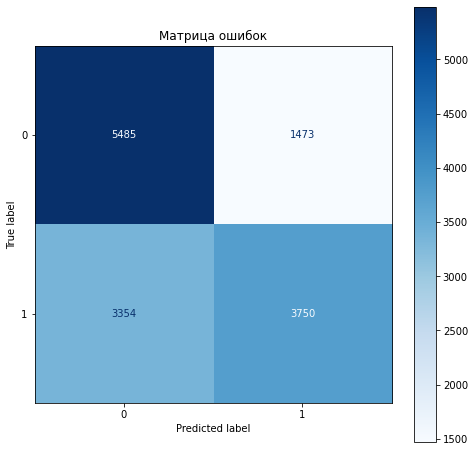

In [ ]:
# Строим матрицу
cm = confusion_matrix(y_test, y_test_pred)

# Получаем метки классов
class_labels = random_search.best_estimator_.named_steps['models'].classes_

# Отображаем матрицу ошибок с метками классов
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', ax=ax)
plt.title('Матрица ошибок')
plt.show()

* __Матрица ошибок:__ Чем больше значение на диагонали, тем лучше модель предсказывает соответствующий класс. Элементы на противоположной диагонали показывают, какие классы модель чаще всего путает;
* __Точность и полнота:__ Высокие значения точности и полноты  указывают на то, что модель хорошо предсказывает  классы.

### Важные факторы

In [ ]:
X_transformed = best_model['preprocessor'].fit_transform(X_train)

# Получаем имена признаков
feature_names = best_model['preprocessor'].get_feature_names_out()

# Получение важностей признаков из лучшей модели
feature_importances = best_model['models'].feature_importances_

# Создание DataFrame с важностями
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортировка по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Вывод результата
feature_importance_df

,Feature,Importance
2,ohe__party_sobriety_had not been drinking,0.248464
1,"ohe__party_sobriety_had been drinking, under i...",0.193859
89,num__insurance_premium,0.136268
6,ohe__vehicle_type_sedan,0.090812
90,num__vehicle_age,0.055848
...,...,...
28,ohe__county_location_alpine,0.000069
81,ohe__county_location_tuolumne,0.000059
51,ohe__county_location_modoc,0.000056
5,ohe__vehicle_type_other,0.000013


На основе предоставленной модели, можно выделить следующие факторы, которые могут влиять на вероятность ДТП:

* party_sobriety (уровень трезвости)
* vehicle_type (тип кузова)
* vehicle_age (возраст авто)
* lighting (освещение)
* weather_1 (погодные условия)
* road_surface (состояние дорожного покрытия)

Проведем дополнительное исследование для фактора party_sobriety (трезвость)

Покажем график зависимости фактора party_sobriety (трезвость) и целевой переменной.

In [ ]:
# Создаем сводную таблицу для подсчета количества случаев
df = factors.groupby(['at_fault', 'weather_1']).size().reset_index(name='count')

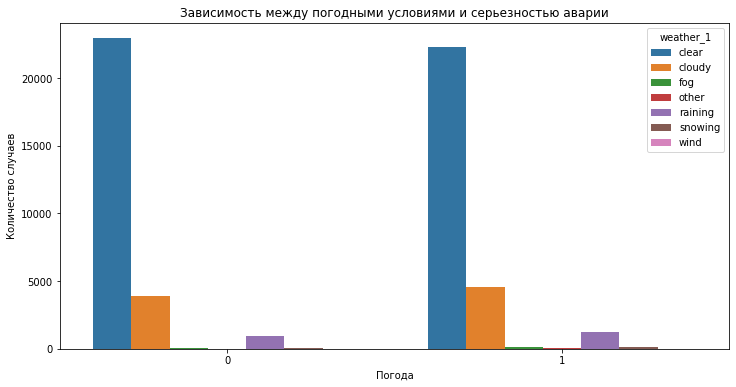

In [ ]:
# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x='at_fault', y='count', hue='weather_1', data=df)
plt.title('Зависимость между погодными условиями и серьезностью аварии')
plt.xlabel('Погода')
plt.ylabel('Количество случаев')
plt.show()

__Вывод:__
1) Из графика видно, что больше всего ДТП были в ясную погоду и водитель был не виновен.  

2) Предложить оборудовать автомобиль системой предупреждения о неблагоприятных погодных условиях. Данная система будет информировать водителя о текущих погодных условиях и рекомендуемой скорости движения, когда он сядет в автомобиль.

## Выводы

1) Кратко опишем лучшую модель:   
Лучшей моделью является - RandomForestClassifier.

Метрика на обучении = 0.71
Метрика на тесте = 0.66

Данные значения метрик говорят о том, что модель не очень хорошо разделяет данные. Это связано с тем, что данные за 2012 год неполные.

2) Насколько возможно создание адекватной системы оценки риска при выдаче авто?

Создание адекватной системы оценки риска при выдаче авто возможно, правда стоит учитывать множество факторов, включая исторические данные о водителях, состояние автомобиля, условия эксплуатации и внешние факторы, такие как погодные и дорожные условия.

3) Какие факторы ещё необходимо собирать, чтобы улучшить модель?
* Техническое состояние авто
* Водительский стаж
* Возраст водителя